In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data

import numpy as np
import pandas as pd
import xarray as xr
import bottleneck as bn
import iris

# Plotting

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

# Scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

In [2]:
# Save filepaths
plotdir = '/g/data/w97/mg5624/plots/RF_project/'
datadir = '/g/data/w97/mg5624/RF_project/'

# Train Both Random Forest Models

## Load Training Data

In [6]:
data = pd.read_csv(datadir + 'training_data/training_data.csv')
data.dropna(axis=0, inplace=True)

predictors_precip = ['Precipitation', 'Acc_3-Month_Precipitation', 'Acc_6-Month_Precipitation', 'Acc_12-Month_Precipitation', 
                     'Acc_24-Month_Precipitation', 'Acc_36-Month_Precipitation', 'Acc_48-Month_Precipitation', 'Runoff', 
                     'ENSO_index', 'IOD_index', 'SAM_index', 'ET', 'PET', 'SMsurf', 'SMroot', 'Sin_month', 'Cos_month']

# predictors with all variables
predictors_full = ['Precipitation', 'Acc_3-Month_Precipitation', 'Acc_12-Month_Precipitation', 'Runoff', 
                   'ENSO_index', 'IOD_index', 'SAM_index', 'ET', 'PET', 'SMsurf', 'SMroot', 'Sin_month', 'Cos_month']


# predictors of variables with timeseries back to 1950 or ealier (these go back to at least 1911)
predictors_long_ts = ['Precipitation', 'Acc_3-Month_Precipitation', 'Acc_12-Month_Precipitation', 'Runoff', 
                      'ENSO_index', 'IOD_index', 'Sin_month', 'Cos_month']

target = 'Drought'

model_types = [
    'full',
    'long_ts',
    'precip',
]

model_title = {
        "full": "Full",
        "long_ts": "Long TS",
        "precip": "Precipitation",
    }

predictors_dict = {
    'full': predictors_full,
    'long_ts': predictors_long_ts,
    'precip': predictors_precip,
}

y = data['Drought']

## Check Dataset is Balanced

In [7]:
def check_if_dataset_is_balanced(data, target, balanced_threshold):
    """
    Checks if the data has balanced drought and no drought targets.
    Args:
    data (pd.DataFrame): Contains all training data
    target (str): name of the target variable ('Drought')
    balanced_threshold (float): threshold for imbalance (e.g. 0.1)
    """
    y = data[target]
    
    class_counts = y.value_counts()
    
    class_proportions = class_counts / len(y)
    
    print("Class counts:\n", class_counts)
    print("\nClass proportions:\n", class_proportions)
    
    # Check if the dataset is balanced
    is_balanced = np.all(np.abs(class_proportions - 0.5) <= balanced_threshold)
    
    if is_balanced:
        print("\nThe dataset is balanced.")
    else:
        print("\nThe dataset is imbalanced.")

check_if_dataset_is_balanced(data, target, 0.1)

Class counts:
 Drought
1    515
0    420
Name: count, dtype: int64

Class proportions:
 Drought
1    0.550802
0    0.449198
Name: count, dtype: float64

The dataset is balanced.


## Train Model

In [8]:
def train_RF_model(data, predictors, target, test_size, random_seed, n_estimators):
    """
    Trains a random forest model.
    Args:
    data (pd.DataFrame): Contains all training data
    predictors (list): list of strings of the names of the predictor variables
    target (str): name of the target variable ('Drought')
    test_size (float): proportion of the data to keep back fro testing
    random_seed (int): random seed value for the RF model
    n_estimators (int): number of estimators to builid RF model with

    Returns:
    clf (sk-learn.RandomForestClassifier): trained random forest classifier
    y_test: the target data held back fro testing
    y_pred: the predicted y data from running the model with the predictor test variables
    """
    X = data[predictors]
    y = data[target]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

    # Create and train the Random Forest model
    clf = RandomForestClassifier(n_estimators=500, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    # print(X_test)
    return clf, y_test, y_pred, X

# clf_long_ts = RandomForestClassifier(n_estimators=500, random_state=42)
# clf_long_ts.fit(X_train_long_ts, y_train_long_ts)

# X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.3, random_state=42)
# X_train_long_ts, X_test_long_ts, y_train_long_ts, y_test_long_ts = train_test_split(X_long_ts, y, test_size=0.3, random_state=42)

clf_full, y_test_full, y_pred_full, X_full = train_RF_model(data, predictors_full, target, 0.3, 42, 500)
clf_long_ts, y_test_long_ts, y_pred_long_ts, X_long_ts = train_RF_model(data, predictors_long_ts, target, 0.3, 42, 500)

clf_precip, y_test_precip, y_pred_precip, X_precip = train_RF_model(data, predictors_precip, target, 0.3, 42, 500)

Index(['Unnamed: 0', 'Year', 'Month', 'Year_Month', 'Location', 'Latitude',
       'Longitude', 'Drought', 'Precipitation', 'Acc_3-Month_Precipitation',
       'Acc_6-Month_Precipitation', 'Acc_12-Month_Precipitation',
       'Acc_24-Month_Precipitation', 'Acc_36-Month_Precipitation',
       'Acc_48-Month_Precipitation', 'Runoff', 'ENSO_index', 'IOD_index',
       'SAM_index', 'ET', 'PET', 'SMsurf', 'SMroot', 'Sin_month', 'Cos_month'],
      dtype='object')
Index(['Unnamed: 0', 'Year', 'Month', 'Year_Month', 'Location', 'Latitude',
       'Longitude', 'Drought', 'Precipitation', 'Acc_3-Month_Precipitation',
       'Acc_6-Month_Precipitation', 'Acc_12-Month_Precipitation',
       'Acc_24-Month_Precipitation', 'Acc_36-Month_Precipitation',
       'Acc_48-Month_Precipitation', 'Runoff', 'ENSO_index', 'IOD_index',
       'SAM_index', 'ET', 'PET', 'SMsurf', 'SMroot', 'Sin_month', 'Cos_month'],
      dtype='object')
Index(['Unnamed: 0', 'Year', 'Month', 'Year_Month', 'Location', 'Latitude',


## Compare Both Models

In [9]:
# Create an array of agreement between the two models
agree = y_pred_full == y_pred_long_ts
                                
# Display y_pred array
print("Predicted classes for the test data of the full model:\n", y_pred_full)
print("\nPredicted classes for the test data of the long timeseries model:\n", y_pred_long_ts)
print("\nPredicted agreement between the two models:\n:", agree)

# Calculate the number of droughts and non-droughts in y_pred
drought_count_full = np.sum(y_pred_full == 1)
non_drought_count_full = np.sum(y_pred_full == 0)

drought_count_long_ts = np.sum(y_pred_long_ts == 1)
non_drought_count_long_ts = np.sum(y_pred_long_ts == 0)

agreement_count = np.sum(agree == True)
disagreement_count = np.sum(agree == False)

print(f"\nNumber of predicted droughts in full model: {drought_count_full}")
print(f"Number of predicted non-droughts in full model: {non_drought_count_full}")

print(f"\nNumber of predicted droughts in long timeseries model: {drought_count_long_ts}")
print(f"Number of predicted non-droughts in long timeseires model: {non_drought_count_long_ts}")

print(f"\nNumber of events on which the two models agree: {agreement_count}")
print(f"Number of events on which the two models disagree: {disagreement_count}")

Predicted classes for the test data of the full model:
 [1 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0
 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1
 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0
 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0]

Predicted classes for the test data of the long timeseries model:
 [1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0
 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1
 0 1 

## Evaluating Models

In [10]:
def calculate_performance_metrics(y_test, y_pred):
    """
    Calculates performance metrics from the RF model
    Args:
    y_test: Data held back from data split for testing
    y_pred: Prediction made by RF Classifier model
    """
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Save results in DataFrame
    performance_data = {
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1],
        'Balance Accuracy': [balanced_accuracy]
    }

    performance_df = pd.DataFrame(performance_data)
    
    return performance_df

performance_df_full = calculate_performance_metrics(y_test_full, y_pred_full)
performance_df_long_ts = calculate_performance_metrics(y_test_long_ts, y_pred_long_ts)

performance_df_precip = calculate_performance_metrics(y_test_precip, y_pred_precip)

print(f"Performance metrics for the full model are: \n{performance_df_full}")
print(f"\n Performance metrics for the long timeseires model are: \n{performance_df_long_ts}")

Performance metrics for the full model are: 
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy
0  0.911032   0.885057  0.968553  0.924925           0.90231

 Performance metrics for the long timeseires model are: 
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy
0  0.896797   0.873563  0.955975  0.912913          0.887823


In [11]:
# See what the scores are like for another random_state
clf_full2, y_test_full2, y_pred_full2, Xfull2 = train_RF_model(data, predictors_full, target, 0.3, 84, 500)
clf_long_ts2, y_test_long_ts2, y_pred_long_ts2, X_long_ts2 = train_RF_model(data, predictors_long_ts, target, 0.3, 84, 500)

performance_df_full2 = calculate_performance_metrics(y_test_full2, y_pred_full2)
performance_df_long_ts2 = calculate_performance_metrics(y_test_long_ts2, y_pred_long_ts2)

print(f"Performance metrics for the full model are: \n{performance_df_full2}")
print(f"\n Performance metrics for the long timeseires model are: \n{performance_df_long_ts2}")

Index(['Unnamed: 0', 'Year', 'Month', 'Year_Month', 'Location', 'Latitude',
       'Longitude', 'Drought', 'Precipitation', 'Acc_3-Month_Precipitation',
       'Acc_6-Month_Precipitation', 'Acc_12-Month_Precipitation',
       'Acc_24-Month_Precipitation', 'Acc_36-Month_Precipitation',
       'Acc_48-Month_Precipitation', 'Runoff', 'ENSO_index', 'IOD_index',
       'SAM_index', 'ET', 'PET', 'SMsurf', 'SMroot', 'Sin_month', 'Cos_month'],
      dtype='object')
Index(['Unnamed: 0', 'Year', 'Month', 'Year_Month', 'Location', 'Latitude',
       'Longitude', 'Drought', 'Precipitation', 'Acc_3-Month_Precipitation',
       'Acc_6-Month_Precipitation', 'Acc_12-Month_Precipitation',
       'Acc_24-Month_Precipitation', 'Acc_36-Month_Precipitation',
       'Acc_48-Month_Precipitation', 'Runoff', 'ENSO_index', 'IOD_index',
       'SAM_index', 'ET', 'PET', 'SMsurf', 'SMroot', 'Sin_month', 'Cos_month'],
      dtype='object')
Performance metrics for the full model are: 
   Accuracy  Precision    Recal

Precipitation_model_performance_metrics_for_seed42.png


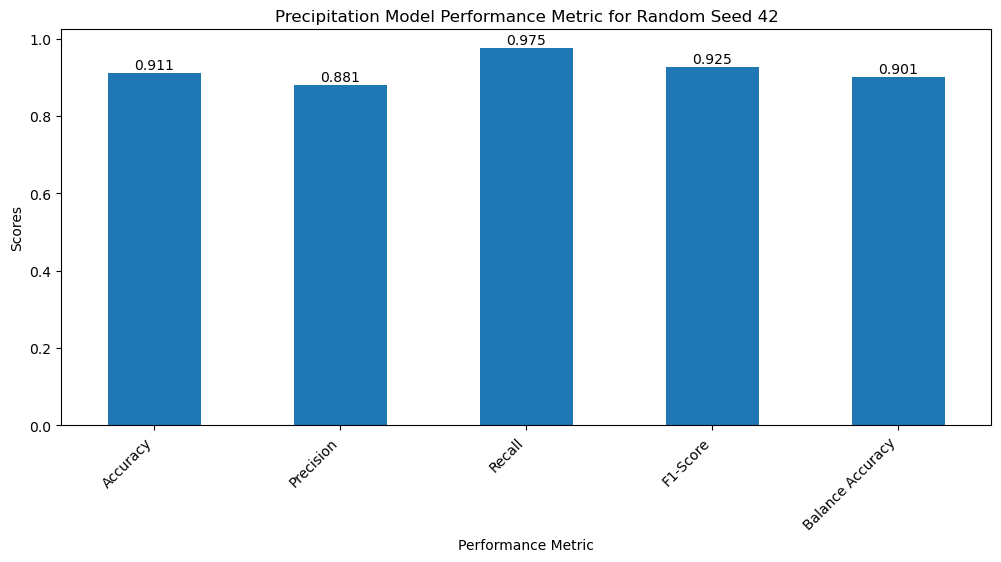

In [25]:
def create_performance_metric_bar_chart(performance_df, random_seed, model_type):
    """
    Creates a bar chart plot of the performance metrics for the model type specified.

    Args:
        performance_df (pd.DataFrame): performance metrics stored in a dataframe
        random_seed (int or str):  if performance metrics from one random_seed then integer value of that seed,
        if performance metrics are averaged from many random_seeds then "average_score"
        modle_type (str): the model type the performance metrics are for, either 'full', 'long_ts', or 'precip'
    """
    performance_df = performance_df.T
    ax = performance_df.plot(kind='bar', figsize=(12, 6), legend=False)
    ax.figure.subplots_adjust(bottom=0.22)
    if isinstance(random_seed, int):
        random_seed_title = f'Random Seed {random_seed}'
    else:
        random_seed_title = f'Average Scores of Multiple Iterations'
    plt.title(f'{model_title[model_type]} Model Performance Metric for {random_seed_title}')
    plt.xlabel('Performance Metric')
    plt.ylabel('Scores')
    plt.xticks(ha='right', rotation=45)

    # Add labels on top of each bar
    for i in ax.patches:
        ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, round(i.get_height(), 3), ha='center')

    # Save figure
    figpath = plotdir + '/performance_metrics/'
    if isinstance(random_seed, int):
        figname = f'{model_title[model_type]}_model_performance_metrics_for_seed{random_seed}.png'
    else:
        figname = f'{model_title[model_type]}_model_performance_metrics_{random_seed}.png'

    print(figname)
    plt.savefig(figpath + figname)
    plt.show()

create_performance_metric_bar_chart(performance_df_precip, 42, 'precip')

                      Full   Long TS
Accuracy          0.911032  0.896797
Precision         0.885057  0.873563
Recall            0.968553  0.955975
F1-Score          0.924925  0.912913
Balance Accuracy  0.902310  0.887823
full_vs_long_ts_model_performance_metrics_for_seed42.png


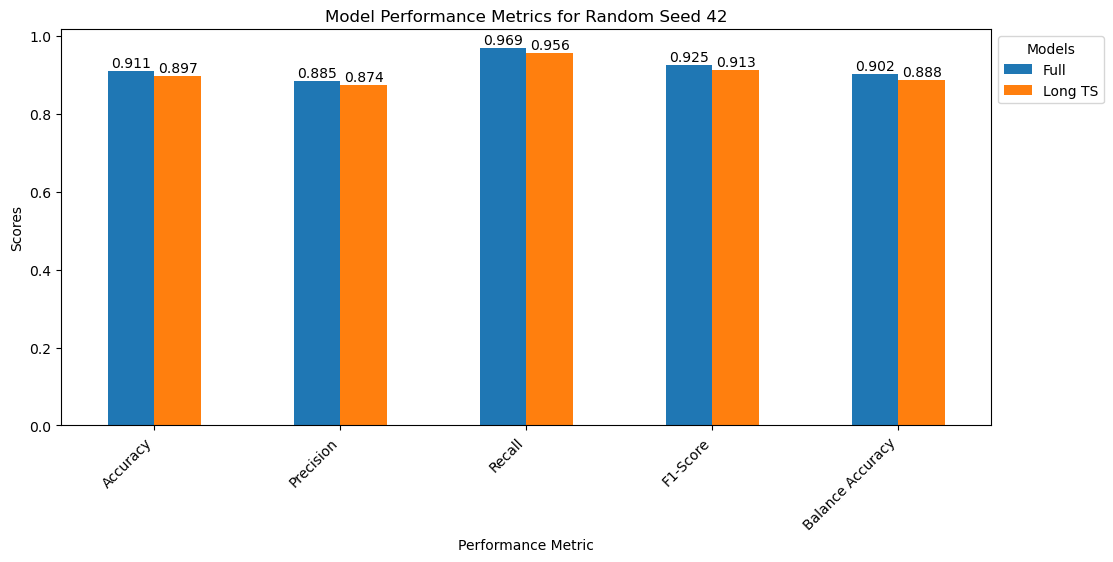

                      Full   Long TS
Accuracy          0.932384  0.921708
Precision         0.892857  0.895706
Recall            0.993377  0.966887
F1-Score          0.940439  0.929936
Balance Accuracy  0.927458  0.918059
full_vs_long_ts_model_performance_metrics_for_seed84.png


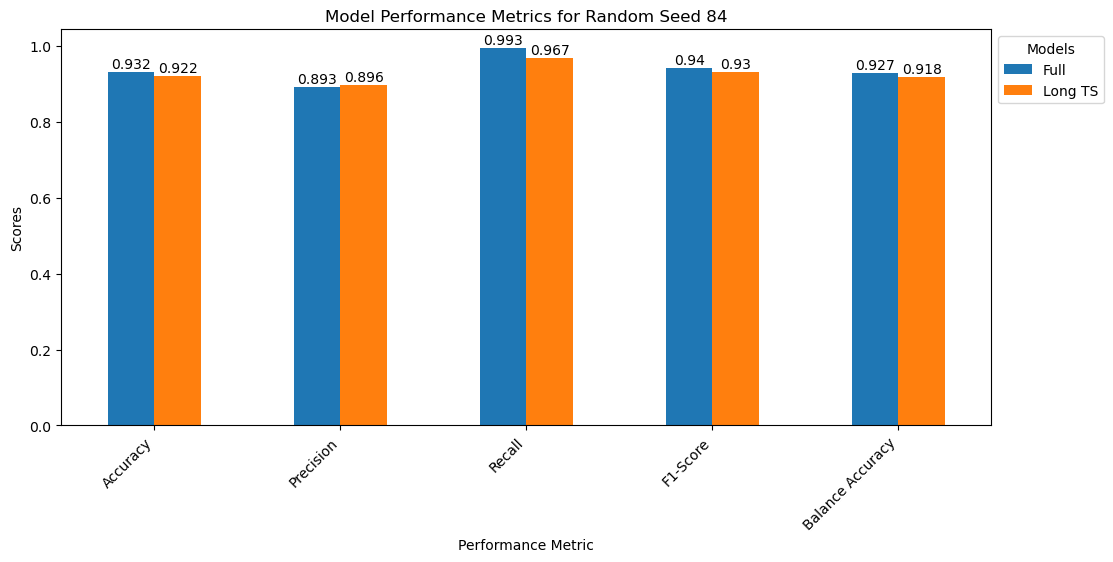

In [13]:
def create_bar_chart_full_vs_long_ts_performance_metrics(
    performance_df_full, performance_df_long_ts, random_seed
):
    """
    Creates a bar plot to compare the performance metrics of the full model and
    long timeseries model.
    
    Args:
        performance_df_full (pd.DataFrame): the performance metrics for the full model
        performance_df_long_ts (pd.DataFrame): the performance metrics for the long timeseries model
        random_seed (int or str):  if performance metrics from one random_seed then integer value of that seed,
        if performance metrics are averaged from many random_seeds then "average_score"
    """
    # Create a barplot comparing the scores of the two models
    performance_frames = [performance_df_full, performance_df_long_ts]
    concat_performance_df = pd.concat(performance_frames)
    
    concat_performance_df.index = ['Full', 'Long TS']
    concat_performance_df = concat_performance_df.T
    print(concat_performance_df)
    
    ax = concat_performance_df.plot(kind='bar', figsize=(12, 6))
    ax.figure.subplots_adjust(bottom=0.22)
    if isinstance(random_seed, int):
        random_seed_title = f'Random Seed {random_seed}'
    else:
        random_seed_title = f'Average Scores of Multiple Iterations'
    plt.title(f'Model Performance Metrics for {random_seed_title}')
    plt.xlabel('Performance Metric')
    plt.ylabel('Scores')
    plt.xticks(ha='right', rotation=45)
    plt.legend(title='Models', loc='upper left', bbox_to_anchor=(1.0, 1.0))

    # Add labels on top of each bar
    for i in ax.patches:
        ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, round(i.get_height(), 3), ha='center')

    # Save figure
    figpath = plotdir + '/performance_metrics/'
    if isinstance(random_seed, int):
        figname = f'full_vs_long_ts_model_performance_metrics_for_seed{random_seed}.png'
    else:
        figname = f'full_vs_long_ts_model_performance_metrics_{random_seed}.png'

    print(figname)
    plt.savefig(figpath + figname)
    plt.show()

create_bar_chart_full_vs_long_ts_performance_metrics(
    performance_df_full, performance_df_long_ts, 42
)

create_bar_chart_full_vs_long_ts_performance_metrics(
    performance_df_full2, performance_df_long_ts2, 84
)

                      Full   Long TS    Precip
Accuracy          0.911032  0.896797  0.911032
Precision         0.885057  0.873563  0.880682
Recall            0.968553  0.955975  0.974843
F1-Score          0.924925  0.912913  0.925373
Balance Accuracy  0.902310  0.887823  0.901356
full_vs_long_ts_vs_precip_model_performance_metrics_for_seed84.png


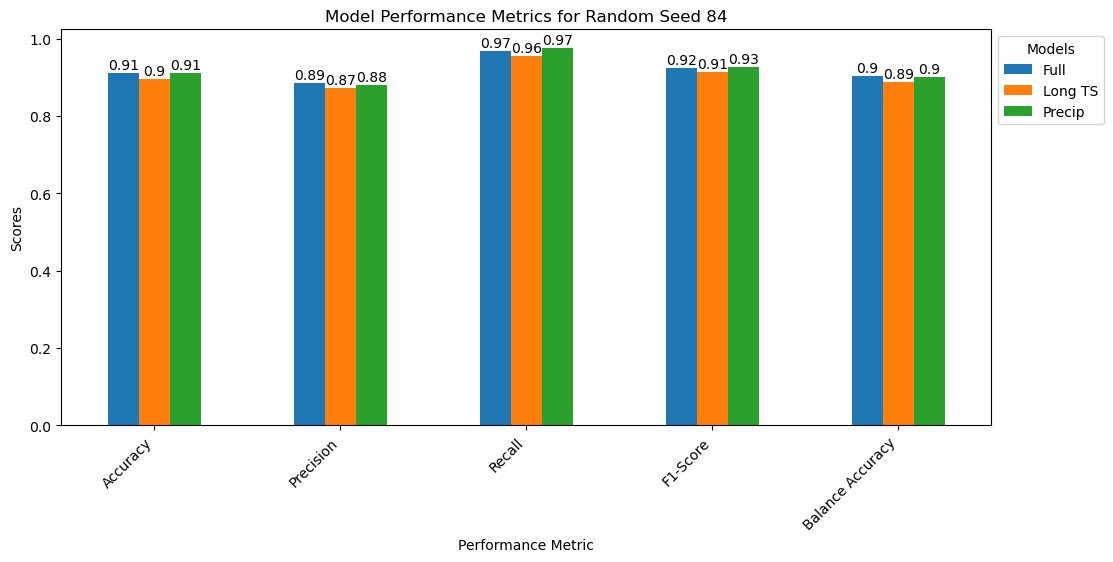

In [31]:
def create_bar_chart_full_vs_long_ts_vs_precip_performance_metrics(
    performance_df_full, performance_df_long_ts, performance_df_precip, random_seed
):
    """
    Creates a bar plot to compare the performance metrics of the full model and
    long timeseries model.
    
    Args:
        performance_df_full (pd.DataFrame): the performance metrics for the full model
        performance_df_long_ts (pd.DataFrame): the performance metrics for the long timeseries model
        random_seed (int or str):  if performance metrics from one random_seed then integer value of that seed,
        if performance metrics are averaged from many random_seeds then "average_score"
    """
    # Create a barplot comparing the scores of the two models
    performance_frames = [performance_df_full, performance_df_long_ts, performance_df_precip]
    concat_performance_df = pd.concat(performance_frames)
    
    concat_performance_df.index = ['Full', 'Long TS', 'Precip']
    concat_performance_df = concat_performance_df.T
    print(concat_performance_df)
    
    ax = concat_performance_df.plot(kind='bar', figsize=(12, 6))
    ax.figure.subplots_adjust(bottom=0.22)
    if isinstance(random_seed, int):
        random_seed_title = f'Random Seed {random_seed}'
    else:
        random_seed_title = f'Average Scores of Multiple Iterations'
    plt.title(f'Model Performance Metrics for {random_seed_title}')
    plt.xlabel('Performance Metric')
    plt.ylabel('Scores')
    plt.xticks(ha='right', rotation=45)
    plt.legend(title='Models', loc='upper left', bbox_to_anchor=(1.0, 1.0))

    # Add labels on top of each bar
    for i in ax.patches:
        ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, round(i.get_height(), 2), ha='center')

    # Save figure
    figpath = plotdir + '/performance_metrics/'
    if isinstance(random_seed, int):
        figname = f'full_vs_long_ts_vs_precip_model_performance_metrics_for_seed{random_seed}.png'
    else:
        figname = f'full_vs_long_ts_vs_precip_model_performance_metrics_{random_seed}.png'

    print(figname)
    plt.savefig(figpath + figname)
    plt.show()

create_bar_chart_full_vs_long_ts_vs_precip_performance_metrics(performance_df_full, performance_df_long_ts, performance_df_precip, 84)

## Variable Importance

Variable Importances for full model:
 [0.03983234 0.08116183 0.1341579  0.03656035 0.26684189 0.06672655
 0.10414892 0.07170589 0.05429234 0.0429109  0.04641019 0.02590539
 0.0293455 ]

Negative Importance Indicators in full model:
 [False False False False False False False False False False False False
 False]

Variable Importances for long timeseries model:
 [0.03983234 0.08116183 0.1341579  0.03656035 0.26684189 0.06672655
 0.10414892 0.07170589 0.05429234 0.0429109  0.04641019 0.02590539
 0.0293455 ]

Negative Importance Indicators in long timeseries model:
 [False False False False False False False False False False False False
 False]


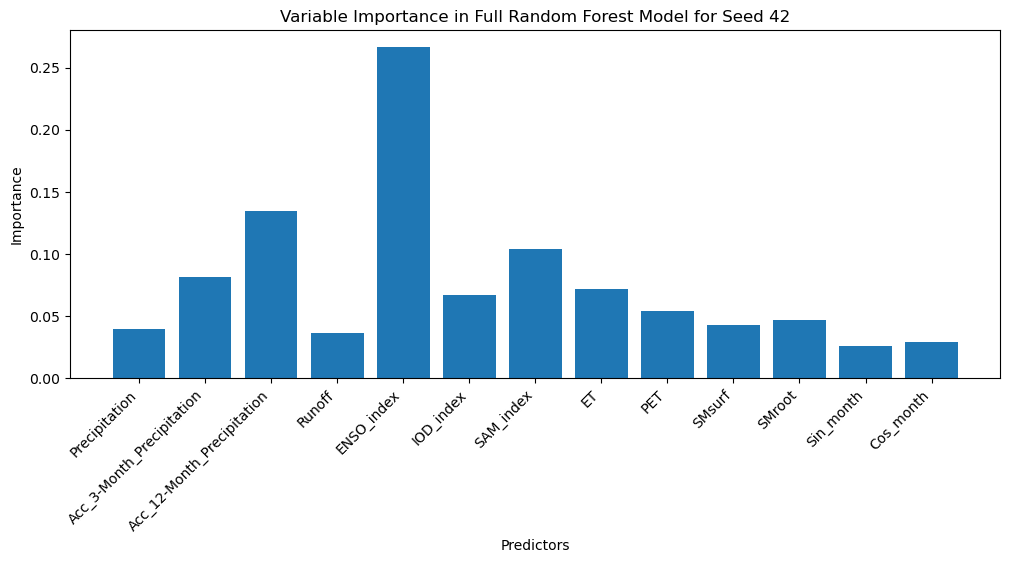

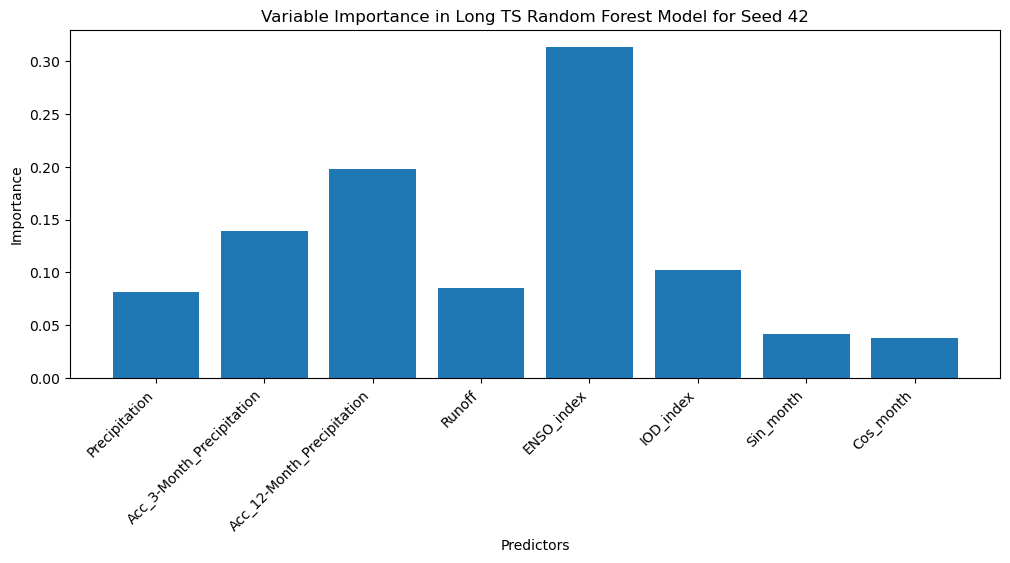

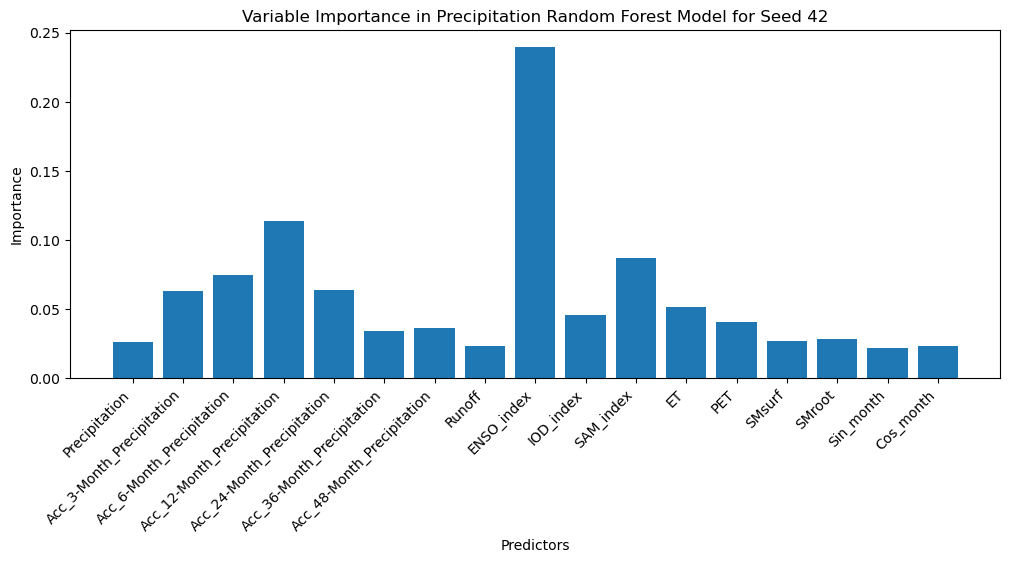

Ranking of predictors based on variable importance for full model:
                     Predictor  Variable Importance  Rank
0                   ENSO_index             0.266842     1
1   Acc_12-Month_Precipitation             0.134158     2
2                    SAM_index             0.104149     3
3    Acc_3-Month_Precipitation             0.081162     4
4                           ET             0.071706     5
5                    IOD_index             0.066727     6
6                          PET             0.054292     7
7                       SMroot             0.046410     8
8                       SMsurf             0.042911     9
9                Precipitation             0.039832    10
10                      Runoff             0.036560    11
11                   Cos_month             0.029346    12
12                   Sin_month             0.025905    13

Ranking of predictors based on variable importance for long timeseries model:
                    Predictor  Variable Im

In [14]:
# Calculate variable importance using the Random Forest model
variable_importance_full = clf_full.feature_importances_
variable_importance_long_ts = clf_long_ts.feature_importances_

variable_importance_precip = clf_precip.feature_importances_

# Check if any variable importances are negative
negative_importance_full = variable_importance_full < 0
negative_importance_long_ts = variable_importance_long_ts < 0

# Display variable importances and negative importance indicators
print("Variable Importances for full model:\n", variable_importance_full)
print("\nNegative Importance Indicators in full model:\n", negative_importance_full)

print("\nVariable Importances for long timeseries model:\n", variable_importance_full)
print("\nNegative Importance Indicators in long timeseries model:\n", negative_importance_full)


def create_variable_importance_barchart(variable_importance, X, model_type, random_seed):
    """
    Plots barchart indicating each variables importances in the model
    Args:
    variable_importance (clf.feature_importance_): importance of each variable
    X: predictor variables
    model_type (str): either "full" or "long_ts"
    random_seed (int): random state of the RF model
    """   
    # Create a bar graph of variable importances
    ax = plt.figure(figsize=(12, 6))
    ax.figure.subplots_adjust(bottom=0.3)
    plt.bar(X.columns, variable_importance)
    plt.xticks(ha='right', rotation=45)
    plt.xlabel('Predictors')
    plt.ylabel('Importance')
    plt.title(f'Variable Importance in {model_title[model_type]} Random Forest Model for Seed {random_seed}')
    figpath = plotdir + '/variable_importance/'
    figname = f'variable_importance_{model_type}_var_model_seed{random_seed}.png'
    plt.savefig(figpath + figname)
    plt.show()

create_variable_importance_barchart(variable_importance_full, X_full, 'full', 42)
create_variable_importance_barchart(variable_importance_long_ts, X_long_ts, 'long_ts', 42)

create_variable_importance_barchart(variable_importance_precip, X_precip, 'precip', 42)

# To display the ranking of the predictors
# Get the indices that would sort the variable importance array in descending order
sorted_indices_full = np.argsort(variable_importance_full)[::-1]
sorted_indices_long_ts = np.argsort(variable_importance_long_ts)[::-1]

# Create a DataFrame to display predictors and their rankings
ranking_df_full = pd.DataFrame({
    'Predictor': X_full.columns[sorted_indices_full],
    'Variable Importance': variable_importance_full[sorted_indices_full],
    'Rank': np.arange(1, len(X_full.columns) + 1)
})

ranking_df_long_ts = pd.DataFrame({
    'Predictor': X_long_ts.columns[sorted_indices_long_ts],
    'Variable Importance': variable_importance_long_ts[sorted_indices_long_ts],
    'Rank': np.arange(1, len(X_long_ts.columns) + 1)
})

# Print the ranking of predictors based on variable importance
print("Ranking of predictors based on variable importance for full model:")
print(ranking_df_full)

print("\nRanking of predictors based on variable importance for long timeseries model:")
print(ranking_df_long_ts)

## Multiple Iterations


     Accuracy  Precision    Recall  F1-score  Balanced Accuracy
0   0.935943   0.907285  0.971631  0.938356           0.935816
1   0.911032   0.880952  0.967320  0.922118           0.905535
2   0.932384   0.908571  0.981481  0.943620           0.923514
3   0.939502   0.910828  0.979452  0.943894           0.937874
4   0.939502   0.916168  0.980769  0.947368           0.934385
..       ...        ...       ...       ...                ...
95  0.907473   0.909605  0.941520  0.925287           0.898033
96  0.935943   0.913793  0.981481  0.946429           0.927716
97  0.932384   0.899408  0.987013  0.941176           0.926577
98  0.939502   0.905882  0.993548  0.947692           0.933282
99  0.943060   0.924051  0.973333  0.948052           0.940865

[100 rows x 5 columns]

     Accuracy  Precision    Recall  F1-score  Balanced Accuracy
0   0.932384   0.901316  0.971631  0.935154           0.932244
1   0.903915   0.879518  0.954248  0.915361           0.898999
2   0.932384   0.903955  0.

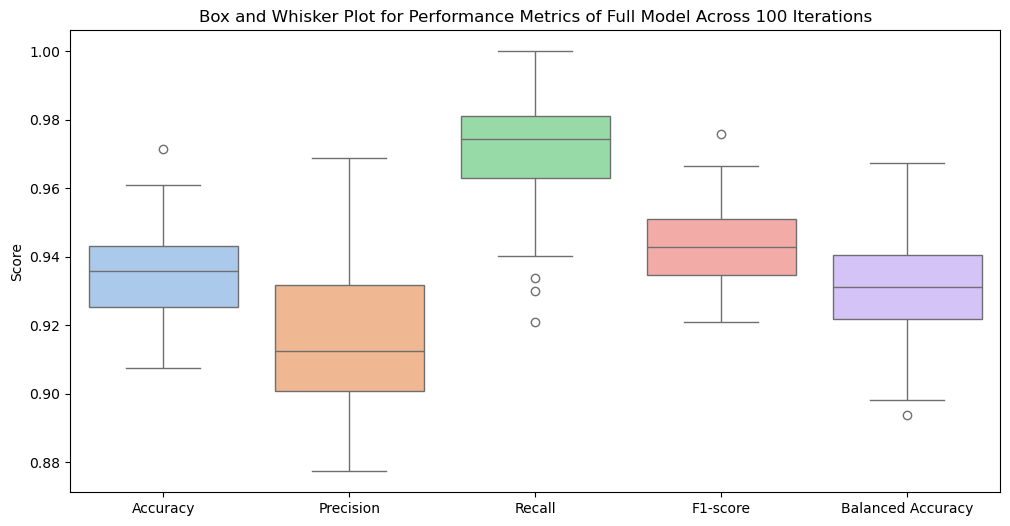

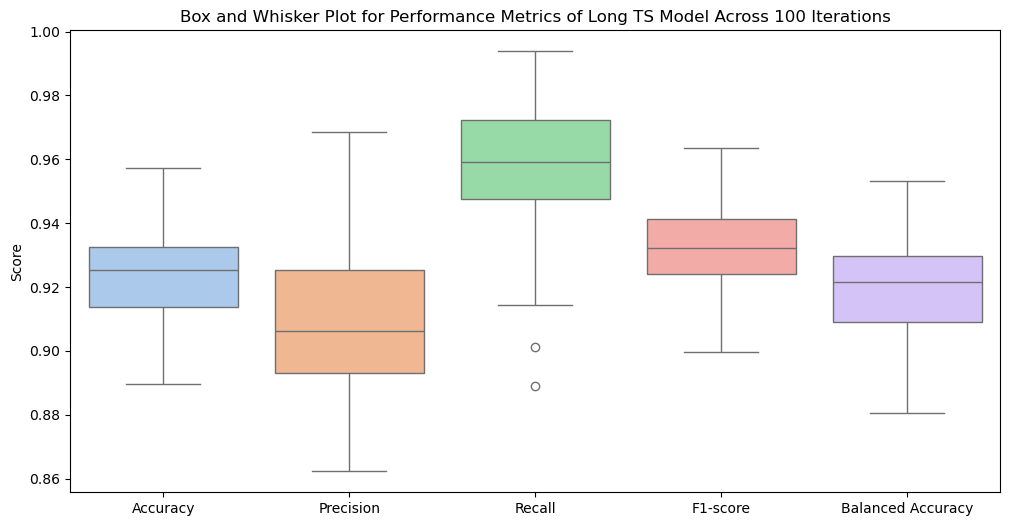

                       Full   Long TS
Accuracy           0.935053  0.923416
Precision          0.916333  0.909488
Recall             0.971798  0.957509
F1-score           0.943023  0.932603
Balanced Accuracy  0.930723  0.919453
full_vs_long_ts_model_performance_metrics_average_score.png


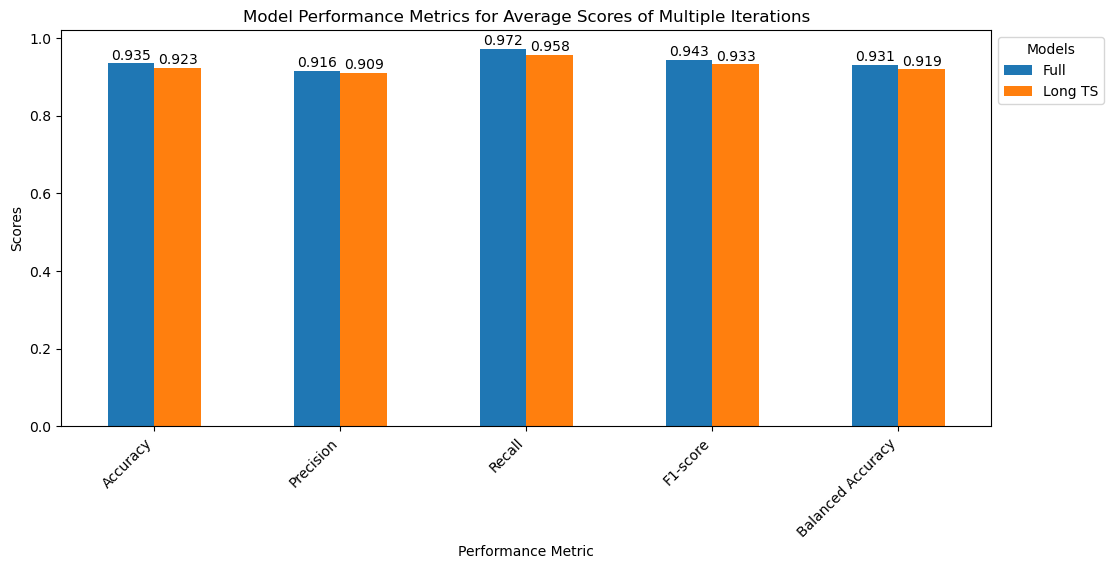

Average Performance metrics for the full model are: 
   Accuracy  Precision    Recall  F1-score  Balanced Accuracy
0  0.935053   0.916333  0.971798  0.943023           0.930723

Average Performance metrics for the long timeseires model are: 
   Accuracy  Precision    Recall  F1-score  Balanced Accuracy
0  0.923416   0.909488  0.957509  0.932603           0.919453


In [15]:
def performance_from_n_iterated_RF_model_seeds(X, y, test_size, n_iterations=100):
    """
    Trains the Random Forest with different seeds to assess stability and generalisability of the model.
    Args:
    X: predictor variables data
    y: target variables data
    test_size (float): proportion of data to be held back for testing
    n_iterations (int): number of iterations of model (default=100)
    """
    seeds = np.arange(n_iterations)
    
    # Initialize arrays to store performance metrics
    accuracy_scores = np.zeros(n_iterations)
    precision_scores = np.zeros(n_iterations)
    recall_scores = np.zeros(n_iterations)
    f1_scores = np.zeros(n_iterations)
    balanced_accuracy_scores = np.zeros(n_iterations)
    
    # Train the model and calculate performance metrics for each iteration
    for i, seed in enumerate(seeds):
        # Split the data into training and testing sets for each iteration
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
        # Train the Random Forest model with a different seed
        clf = RandomForestClassifier(n_estimators=500, random_state=seed)
        clf.fit(X_train, y_train)
    
        # Predict on test data
        y_pred = clf.predict(X_test)
    
        # Calculate performance metrics
        accuracy_scores[i] = accuracy_score(y_test, y_pred)
        precision_scores[i] = precision_score(y_test, y_pred)
        recall_scores[i] = recall_score(y_test, y_pred)
        f1_scores[i] = f1_score(y_test, y_pred)
        balanced_accuracy_scores[i] = balanced_accuracy_score(y_test, y_pred)
        
    # Create a DataFrame to store the performance metrics for each iteration
    performance_df = pd.DataFrame({
        'Accuracy': accuracy_scores,
        'Precision': precision_scores,
        'Recall': recall_scores,
        'F1-score': f1_scores,
        'Balanced Accuracy': balanced_accuracy_scores
    })
    print('\n', performance_df)

    return performance_df


def find_mean_performance_metrics(performance_df):
    """
    Find the mean of each performance metric.
    Args:
    performance_df (pd.DataFrame): 
        dataframe of the performance metrics from each iteration of the RF model
    """
    print(performance_df)
    mean_performance_metric = performance_df.mean(axis=0)
    print(mean_performance_metric)
    mean_performance_df = mean_performance_metric.to_frame().T
    print(mean_performance_df)
    
    return mean_performance_df
    

def create_performance_metrics_boxplot(performance_df, model_type):
    """
    Plots a boxplot of the performance metric scores
    Args:
        performance_df (pd.DataFrame): dataframe of the performance metrics from each iteration of the RF model
        model_type (str): describing the type of RF model either "full", "long_ts", or "precip"
    """    
    # Draw a  box and whisker plot to display the results of each performance metric across 30 iterations
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=performance_df, palette="pastel")
    plt.ylabel('Score')
    plt.title(f'Box and Whisker Plot for Performance Metrics of {model_title[model_type]} Model Across 100 Iterations')

    # Save plot
    figpath = plotdir + '/performance_metrics/'
    figname = f'performance_metric_boxplot_{model_type}_var_model.png'
    plt.savefig(figpath + figname)
    
    plt.show()


    
n_iterated_performance_df_full = performance_from_n_iterated_RF_model_seeds(X_full, y, 0.3)
n_iterated_performance_df_long_ts = performance_from_n_iterated_RF_model_seeds(X_long_ts, y, 0.3)

mean_performance_df_full = find_mean_performance_metrics(n_iterated_performance_df_full)
mean_performance_df_long_ts = find_mean_performance_metrics(n_iterated_performance_df_long_ts)

create_performance_metrics_boxplot(n_iterated_performance_df_full, "full")
create_performance_metrics_boxplot(n_iterated_performance_df_long_ts, "long_ts")

create_bar_chart_full_vs_long_ts_performance_metrics(
    mean_performance_df_full, mean_performance_df_long_ts, 'average_score'
)

print(f"Average Performance metrics for the full model are: \n{mean_performance_df_full}")
print(f"\nAverage Performance metrics for the long timeseires model are: \n{mean_performance_df_long_ts}")
print(f"\nAverage Performance metrics for the long timeseires model are: \n{mean_performance_df_precip}")

In [16]:
mean_performance_df_full = find_mean_performance_metrics(performance_df_full)
mean_performance_df_long_ts = find_mean_performance_metrics(performance_df_long_ts)


print(f"Performance metrics for the full model are: \n{performance_df_full}")
print(f"\n Performance metrics for the long timeseires model are: \n{performance_df_long_ts}")

   Accuracy  Precision    Recall  F1-Score  Balance Accuracy
0  0.911032   0.885057  0.968553  0.924925           0.90231
Accuracy            0.911032
Precision           0.885057
Recall              0.968553
F1-Score            0.924925
Balance Accuracy    0.902310
dtype: float64
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy
0  0.911032   0.885057  0.968553  0.924925           0.90231
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy
0  0.896797   0.873563  0.955975  0.912913          0.887823
Accuracy            0.896797
Precision           0.873563
Recall              0.955975
F1-Score            0.912913
Balance Accuracy    0.887823
dtype: float64
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy
0  0.896797   0.873563  0.955975  0.912913          0.887823
Performance metrics for the full model are: 
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy
0  0.911032   0.885057  0.968553  0.924925           0.90231

 Performance metrics for


     Accuracy  Precision    Recall  F1-score  Balanced Accuracy
0   0.935943   0.907285  0.971631  0.938356           0.935816
1   0.911032   0.880952  0.967320  0.922118           0.905535
2   0.932384   0.908571  0.981481  0.943620           0.923514
3   0.939502   0.910828  0.979452  0.943894           0.937874
4   0.939502   0.916168  0.980769  0.947368           0.934385
..       ...        ...       ...       ...                ...
95  0.907473   0.909605  0.941520  0.925287           0.898033
96  0.935943   0.913793  0.981481  0.946429           0.927716
97  0.932384   0.899408  0.987013  0.941176           0.926577
98  0.939502   0.905882  0.993548  0.947692           0.933282
99  0.943060   0.924051  0.973333  0.948052           0.940865

[100 rows x 5 columns]
    Accuracy  Precision    Recall  F1-score  Balanced Accuracy
0   0.935943   0.907285  0.971631  0.938356           0.935816
1   0.911032   0.880952  0.967320  0.922118           0.905535
2   0.932384   0.908571  0.98

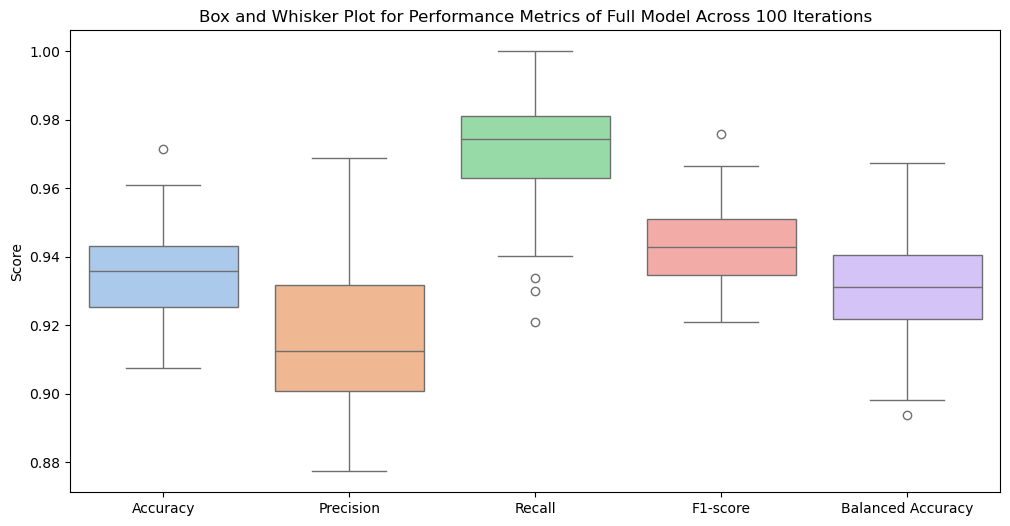

Full_model_performance_metrics_average_score.png


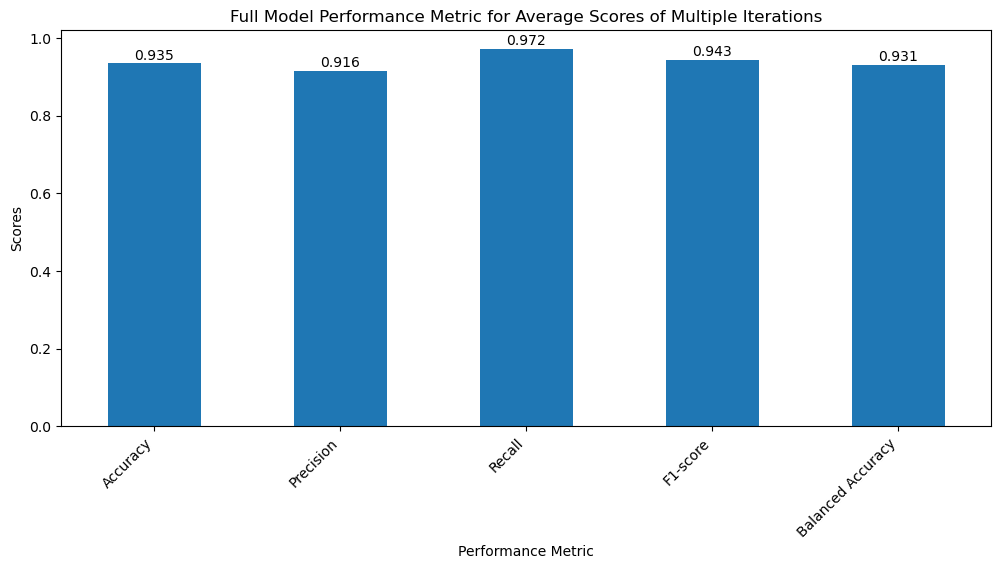


     Accuracy  Precision    Recall  F1-score  Balanced Accuracy
0   0.932384   0.901316  0.971631  0.935154           0.932244
1   0.903915   0.879518  0.954248  0.915361           0.898999
2   0.932384   0.903955  0.987654  0.943953           0.922399
3   0.925267   0.893082  0.972603  0.931148           0.923338
4   0.925267   0.919255  0.948718  0.933754           0.922359
..       ...        ...       ...       ...                ...
95  0.903915   0.904494  0.941520  0.922636           0.893488
96  0.918149   0.906433  0.956790  0.930931           0.911168
97  0.914591   0.886905  0.967532  0.925466           0.908963
98  0.921708   0.888889  0.980645  0.932515           0.914926
99  0.943060   0.918750  0.980000  0.948387           0.940382

[100 rows x 5 columns]
    Accuracy  Precision    Recall  F1-score  Balanced Accuracy
0   0.932384   0.901316  0.971631  0.935154           0.932244
1   0.903915   0.879518  0.954248  0.915361           0.898999
2   0.932384   0.903955  0.98

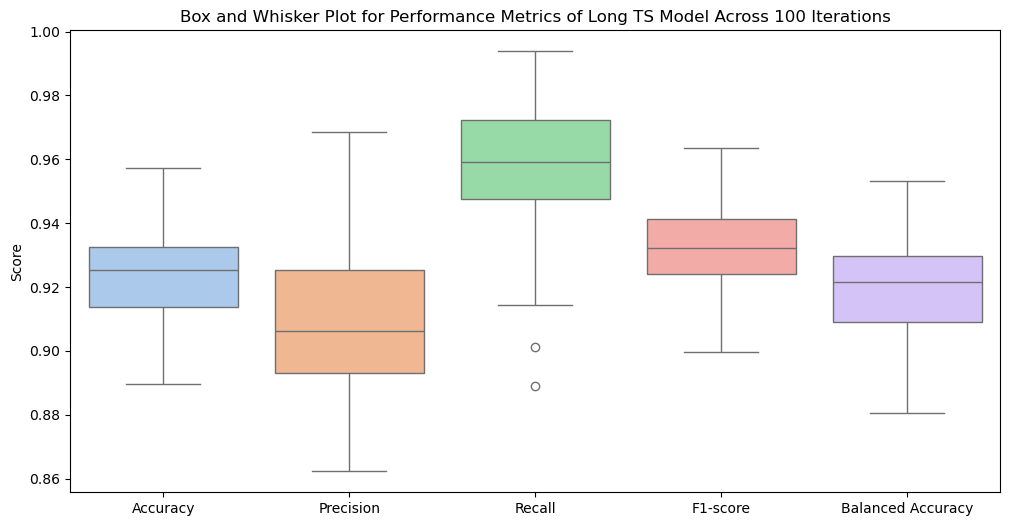

Long TS_model_performance_metrics_average_score.png


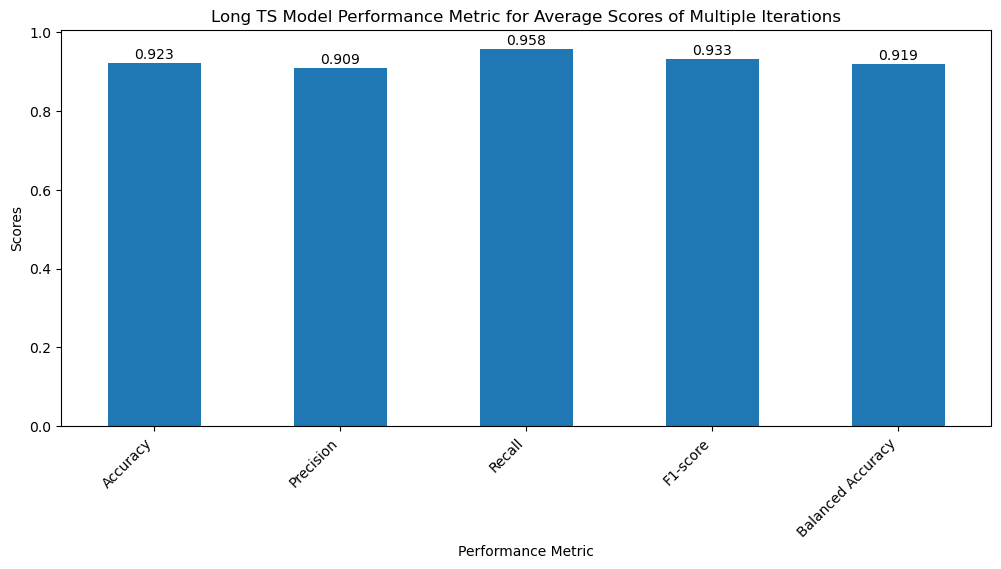


     Accuracy  Precision    Recall  F1-score  Balanced Accuracy
0   0.928826   0.900662  0.964539  0.931507           0.928698
1   0.921708   0.887574  0.980392  0.931677           0.915977
2   0.943060   0.914773  0.993827  0.952663           0.933888
3   0.935943   0.900000  0.986301  0.941176           0.933891
4   0.932384   0.910180  0.974359  0.941176           0.927179
..       ...        ...       ...       ...                ...
95  0.911032   0.905556  0.953216  0.928775           0.899335
96  0.932384   0.913295  0.975309  0.943284           0.924629
97  0.928826   0.898810  0.980519  0.937888           0.923331
98  0.943060   0.911243  0.993548  0.950617           0.937250
99  0.946619   0.924528  0.980000  0.951456           0.944198

[100 rows x 5 columns]
    Accuracy  Precision    Recall  F1-score  Balanced Accuracy
0   0.928826   0.900662  0.964539  0.931507           0.928698
1   0.921708   0.887574  0.980392  0.931677           0.915977
2   0.943060   0.914773  0.99

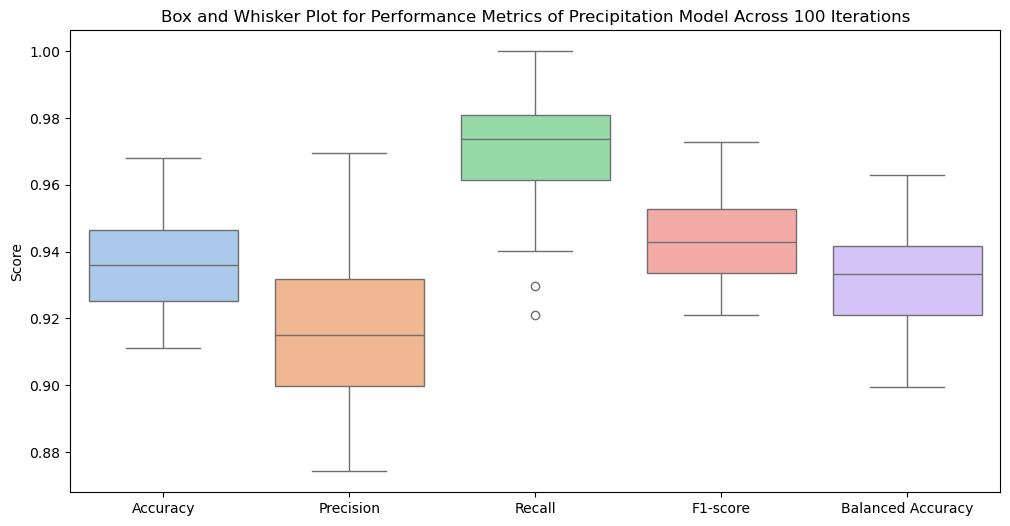

Precipitation_model_performance_metrics_average_score.png


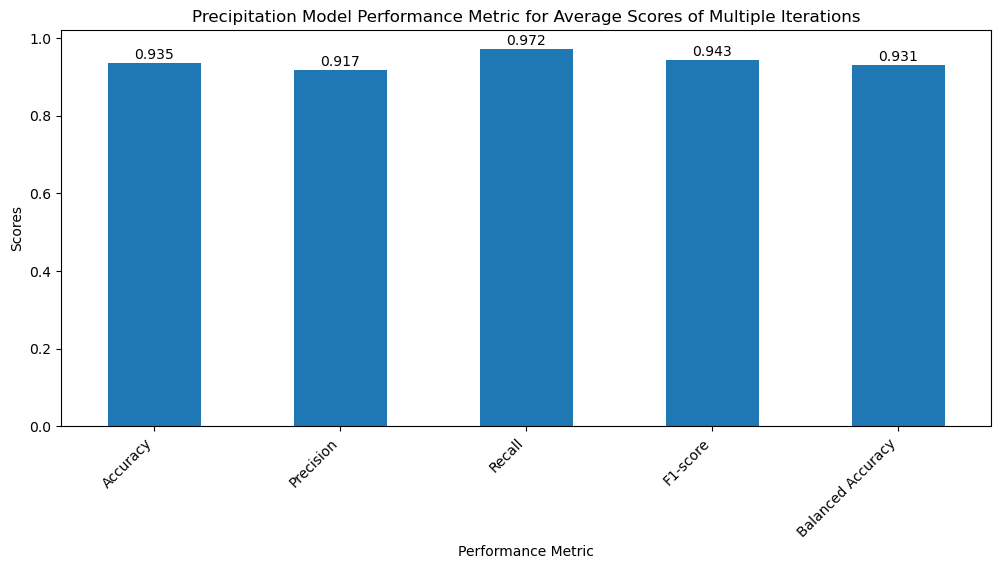

In [32]:
def combine_all_iterative_functions(data, predictors, target, test_size, model_type, n_iterations=100):
    """
    Trains n_iterations RF models with different random states and creates plots of mean performance metrics and
    variable importance. Also creates boxplots to show the spread of the performance metrics over the iterations.

    Args:
        data (pd.DataFrame): training data
        predictors (list): list of all the predictors for the model
        target (str): target variable for the model
        test_size (float): proportion of training data to hold back for testing
        model_type (str): describing the type of RF model either "full", "long_ts", or "precip"
        n_iterations (int): number of RF models to train (default=100)
    """
    X = data[predictors]
    y = data[target]

    performance_df = performance_from_n_iterated_RF_model_seeds(X, y, test_size, n_iterations)
    mean_performance_df = find_mean_performance_metrics(performance_df)

    create_performance_metrics_boxplot(performance_df, model_type)
    create_performance_metric_bar_chart(mean_performance_df, 'average_score', model_type)

    return performance_df, mean_performance_df

different_models_n_performance_df = []
different_models_mean_performance_df = []
for model in model_types:
    predictors = predictors_dict[model]
    performance_df_from_n_seeds, mean_performance_df = combine_all_iterative_functions(data, predictors, 'Drought', 0.3, model)
    different_models_n_performance_df.append(performance_df_from_n_seeds)
    different_models_mean_performance_df.append(mean_performance_df)

                       Full   Long TS    Precip
Accuracy           0.935053  0.923416  0.935374
Precision          0.916333  0.909488  0.917069
Recall             0.971798  0.957509  0.971522
F1-score           0.943023  0.932603  0.943283
Balanced Accuracy  0.930723  0.919453  0.931178
full_vs_long_ts_vs_precip_model_performance_metrics_average_score.png


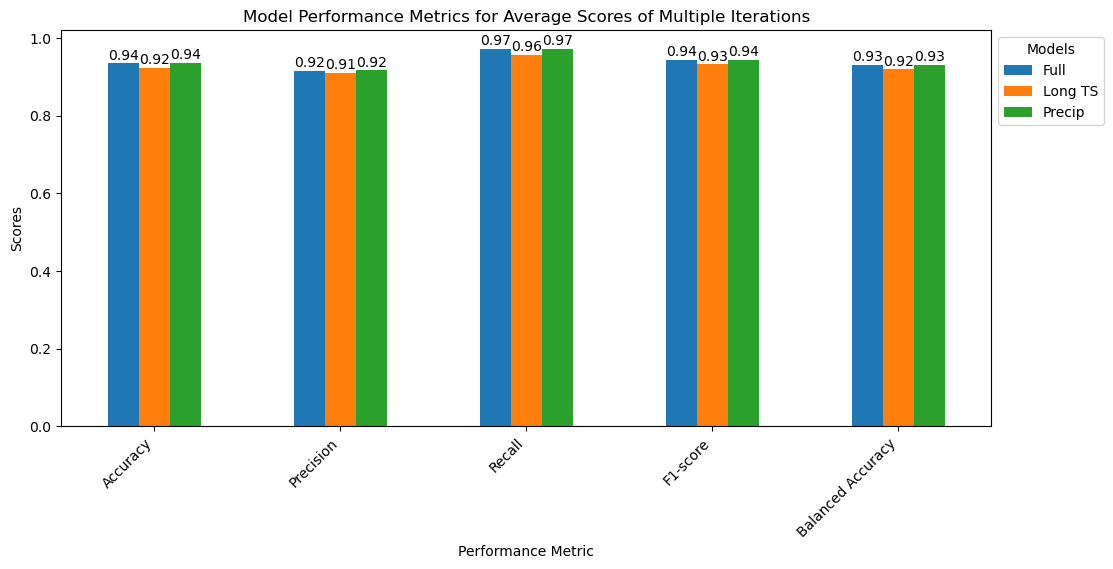

In [35]:
mean_performance_df_full = different_models_mean_performance_df[0]
mean_performance_df_long_ts = different_models_mean_performance_df[1]
mean_performance_df_precip = different_models_mean_performance_df[2]

create_bar_chart_full_vs_long_ts_vs_precip_performance_metrics(mean_performance_df_full, mean_performance_df_long_ts, mean_performance_df_precip, 'average_score')